##  Deforestation Data

### Introduction
- This notebook provides the code for analyzing deforestation data in the legal amazon
- There are two data files to use:  
  - 1_Shapefiles_Amazon 
  - 2_Yearly_Deforestation(Source: **[TerraBrasilis](http://terrabrasilis.dpi.inpe.br/)**)

###  Notebook Outline:
- [Set up](#setup) (run this first!)
- [Read Shapfiles](#shapefiles) 
- [Summary Statistics](#summary) 
- [Figures](#figures) 
- [Maps](#maps) 

<a id='setup'></a>
## Set up

In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d
import pyproj
import rasterstats
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio
import rasterstats
from rasterio.mask import mask
from rasterio.plot import show
import plotly.express as px


In [2]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

<a id='shapefiles'></a>
## 1. Read Shapfiles

- Please download the required datasets from "Data" folder.
- you will find the exact data files in each of the subfoler.

#### 1.1 Read the Legal Amazon shape file

In [3]:
amazon = geopandas.read_file("amazonia_legal.shp")
## dissolve to states level
amazon_state= amazon.dissolve(by="NAME_1",aggfunc="sum")

In [4]:
amazon_state = amazon_state.reset_index('NAME_1')
amazon_state.rename(columns = {'NAME_1':'STATE'}, inplace = True)
amazon_state.replace('Amazonas','AM',inplace = True )
amazon_state.replace('Amapá','AP',inplace = True )
amazon_state.replace('Maranhão','MA',inplace = True )
amazon_state.replace('Mato Grosso','MT',inplace = True )
amazon_state.replace('Pará','PA',inplace = True )
amazon_state.replace('Rondônia','RO',inplace = True )
amazon_state.replace('Roraima','RR',inplace = True )
amazon_state.replace('Tocantins','TO',inplace = True )
amazon_state.replace('Acre','AC',inplace = True )
amazon_state.replace('Amazonas','AM',inplace = True )
amazon_state.replace('Amapá','AP',inplace = True )
amazon_state.replace('Maranhão','MA',inplace = True )
amazon_state.replace('Mato Grosso','MT',inplace = True )
amazon_state.replace('Pará','PA',inplace = True )
amazon_state.replace('Rondônia','RO',inplace = True )
amazon_state.replace('Roraima','RR',inplace = True )
amazon_state.replace('Tocantins','TO',inplace = True )
choose = [len(x) == 2 for x in amazon_state['STATE']]
amazon_state = amazon_state[choose]

<AxesSubplot:>

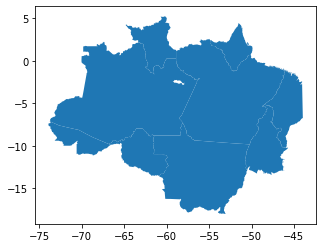

In [5]:
amazon_state.plot()

#### 1.2 Read yearly deforestation shape file

In [6]:
Def_all =geopandas.read_file("yearly_deforestation.shp")

In [7]:
# Projection check
amazon_state.crs== Def_all.crs

False

In [8]:
Def_all= Def_all.to_crs(amazon_state.crs)

In [9]:
amazon_state.crs== Def_all.crs

True

<a id='summary'></a>
## 2. Summary Statistics

#### 3.1 Total loss over the years 2018-2019 for each stata

In [10]:
Def_State_total = Def_all.groupby('STATE').sum().AREA_KM
Def_State_total.head(10)

STATE
AC     3800.752172
AM     8826.323631
AP      423.046776
MA     5275.950700
MT    16746.170987
PA    35338.186876
RO    11169.410230
RR     2761.169870
TO      607.957687
Name: AREA_KM, dtype: float64

#### 3.2 Variations of deforestation aross states and years

In [ ]:
# Generate many dataframes of different years
# def_2008 - def_2019 
for i in Def_all.YEAR.unique():   
    i_str = str(i)[:4]
    exec('''def_%s = Def_all[Def_all['YEAR'] == i].groupby('STATE').sum().reset_index('STATE')'''%(i_str))
    exec('''def_%s = def_%s.rename(columns = {'AREA_KM': 'AREA_KM_%s'})'''%(i_str,i_str,i_str))
    exec('''def_%s = def_%s[['STATE','AREA_KM_%s']]'''%(i_str,i_str,i_str))


In [ ]:
i = 2008
for j in range(2009,2020):
    exec('''def_%s = def_%s.merge(def_%s, how = 'left')'''%(i,i,j))

In [ ]:
plt.boxplot([def_2008.AREA_KM_2008,def_2009.AREA_KM_2009,def_2010.AREA_KM_2010, \
             def_2011.AREA_KM_2011,def_2012.AREA_KM_2012,def_2013.AREA_KM_2013,def_2014.AREA_KM_2014, \
             def_2015.AREA_KM_2015,def_2016.AREA_KM_2016,def_2017.AREA_KM_2017,def_2018.AREA_KM_2018,def_2019.AREA_KM_2019])
# plt.xlabel(np.arange(2008,2020))
plt.xlabel('Year')
plt.ylabel('Deforestation Area')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12],[r'$2008$', r'$2009$', r'$2010$', r'$2011$', r'$2012$', \
                                                r'$2013$', r'$2014$', r'$2015$', r'$2016$', r'$2017$', r'$2018$', r'$2019$'])

#### 3.3 Prepare state-year datasets to make figure 2

In [ ]:
Deforestation_state_year = def_2008
Deforestation_state_year = Deforestation_state_year.set_index('STATE')
Deforestation_state_year_T = pd.DataFrame(Deforestation_state_year.values.T,columns=Deforestation_state_year.index)
year = list(range(2008,2020))
Deforestation_state_year_T['YEAR'] = year
Deforestation_state_year_T

<a id='figures'></a>
## 3.  Figures 

####  Figure 1. Total Defrestation of the Legal Amazon in Each Brazilian State 2008 - 2019

In [ ]:
plt.bar(Def_all.groupby('STATE').sum().index,Def_all.groupby('STATE').sum().AREA_KM)
plt.plot(Def_all.groupby('STATE').sum().index,Def_all.groupby('STATE').sum().AREA_KM, 'c.-')
plt.xlabel('State')
plt.ylabel('Area of Deforestation(KM)')
for x, y in zip(Def_all.groupby('STATE').sum().index, Def_all.groupby('STATE').sum().AREA_KM):
    plt.text(x, y+0.3, '%.0f'%y, ha='center', va='bottom', fontsize=10.5)
plt.title('Total Defrestation of the Legal Amazon in Each Brazilian State 2008 - 2019')
ax=plt.gca()
plt.ylim(0,40000)
plt.savefig("Figure 1 Total Defrestation of the Legal Amazon in Each Brazilian State 2008 - 2019.png")


#### Figure 2. Deforestation of Legal Amazon Area across Brazalian states over years 2008-2019

In [ ]:
ac = Deforestation_state_year_T['AC']
am = Deforestation_state_year_T['AM']
ap = Deforestation_state_year_T['AP']
ma = Deforestation_state_year_T['MA']
mt = Deforestation_state_year_T['MT']
pa = Deforestation_state_year_T['PA']
ro = Deforestation_state_year_T['RO']
rr = Deforestation_state_year_T['RR']
to = Deforestation_state_year_T['TO']
year = Deforestation_state_year_T['YEAR']
plt.title('Deforestation in Different states over Years')
plt.plot(year, ac, color='green', label='AC')
plt.plot(year, am, color='DarkKhaki', label='AM')
plt.plot(year, ap,  color='skyblue', label='AP')
plt.plot(year, ma, color='SteelBlue', label='MA')
plt.plot(year, mt, color='Crimson', label='MT')
plt.plot(year, pa, color='purple', label='PA')
plt.plot(year, ro,  color='LightSalmon', label='RO')
plt.plot(year, rr, color='LightSeaGreen', label='RR')
plt.plot(year, to, color='gray', label='TO')
plt.legend(title = 'State', ncol = 2) 
plt.xlabel('Years')
plt.ylabel('Area of Deforestation(KM)')
plt.savefig("Figure2 Deforestation of Legal Amazon Area across Brazalian states over years 2008-2019.png")

#### Figure 3. Choropleth map

In [ ]:
import plotly.express as px
import plotly.express as px
import geopandas as gpd
import json
with open('brazil_geo.json', 'r') as f:
    state = json.load(f) 

In [ ]:
Def_all_year_state = Def_all.groupby(['YEAR','STATE']).sum().reset_index('YEAR').reset_index('STATE')
Def_all_year_state = Def_all_year_state[['STATE','YEAR','AREA_KM']]
GeoDef_all_year_state = amazon_state.merge(Def_all_year_state,how='left')

In [ ]:
fig = px.choropleth(
    GeoDef_all_year_state,
    geojson=state, locations='STATE',
    color="AREA_KM",      
    hover_name='STATE',
    animation_frame="YEAR",
    range_color=(0,5000),
    labels={'AREA_KM':'Area of Deforestation(KM)'},
    color_continuous_scale="Reds",
    )
fig.update_layout(
    title_text = 'Deforestation',
    geo_scope='south america',
 )
fig.show()

<a id='maps'></a>
## 4. Maps

#### Figre 4. Total Deforestation of Legal Amazon in Brazlian States over Years 2008-2019

In [ ]:
f,a = plt.subplots(figsize=(15,15))
amazon.plot(ax=a,facecolor = 'none', edgecolor = 'gray')
Def_all.plot(color="red",markersize=10,ax=a, legend=True)
plt.savefig("Figre 4. Total Deforestation of Legal Amazon in Brazlian States over Years 2008-2019.png")

##  Then End